In [10]:
import spacy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
from spacy import displacy

nlp = spacy.load("de_core_news_lg")
# nlp = spacy.load("de_dep_news_trf") # no NER!!

patterns = [
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "^(January|February|March|April|Mai|June|July|August|September|October|November|December|Feber|Nov\\.)$"}}, {"TEXT": {"REGEX": "^[0-9]{4}$"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "^(Januar|Februar|März|April|Mai|Juni|Juli|August|September|Oktober|November|Dezember|Feber|Nov\\.)$"}}, {"TEXT": {"REGEX": "^[0-9]{4}$"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "^(Jan|Feb|Mär|Apr|Mai|Jun|Jul|Aug|Sep|Okt|Nov|Dez|Feber|Nov\\.)$"}}, {"TEXT": {"REGEX": "^[0-9]{4}$"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "^(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec|Feber|Nov\\.)$"}}, {"TEXT": {"REGEX": "^[0-9]{4}$"}}]},
    {"label": "DATE", "pattern": [{"TEXT": {"REGEX": "^[0-9]{4}$"}}]},
    {"label": "PERSON", "pattern": [{"TEXT": {"REGEX": "^(Aufn)\\.$"}}, {"TEXT": {"REGEX": "^[A-Z][a-z]+$"}}]}, 
    {"label": "FILM", "pattern": [{"LOWER": "rollfilm"}, {"IS_ASCII": True, "OP": "+"}]},
    {"label": "FILM", "pattern": [{"LOWER": "film"}, {"IS_ASCII": True, "OP": "+"}]}
]

ruler = nlp.add_pipe("entity_ruler", before="ner")
ruler.add_patterns(patterns)

In [11]:
def process_text_file(file_path):
    with open(file_path, "r") as file:
        txt = file.read()
    doc = nlp(txt)
    return doc

# nlp = spacy.load("de_core_news_lg")

doc = process_text_file("ab_output/18.txt")
displacy.render(doc, style='ent')

In [3]:
doc = process_text_file("ab_output/18.txt")
displacy.render(doc, style='ent')

In [43]:
doc

Breitenstein geg.
Schneeberg u.Rax
Aufn.Meisinger,Mai 1961
Rollfilm Nr.94/5+6,


In [27]:
def process_text_file(file_path):
    with open(file_path, "r") as file:
        txt = file.read()
    doc = nlp(txt)
    return doc


def extract_entities(doc):
    entities = {
        "Location": None,
        "Description": None,
        "Date": None,
        "Photographer": None,
        "Film": None
    }
    
    for ent in doc.ents:
        if ent.label_ == "GPE" or ent.label_ == "LOC":
            if entities["Location"] is None:
                entities["Location"] = ent.text
            else:
                entities["Location"] += " " + ent.text
        elif ent.label_ == "DATE":
            if entities["Date"] is None:
                entities["Date"] = ent.text
            else:
                entities["Date"] += " " + ent.text
        elif ent.label_ == "PERSON" or ent.label_ == "PER":
            if entities["Photographer"] is None:
                entities["Photographer"] = ent.text
            else:
                entities["Photographer"] += " " + ent.text
        elif ent.label_ == "FILM":
            if entities["Film"] is None:
                entities["Film"] = ent.text
            else:
                entities["Film"] += " " + ent.text
        else:
            if entities["Description"] is None:
                entities["Description"] = ent.text
            else:
                entities["Description"] += " " + ent.text

    return entities

In [28]:
import json
import os

txts_folder = "ab_output"

# Process each text file in the folder
for txt_file in os.listdir(txts_folder):
    file_path = os.path.join(txts_folder, txt_file)
    doc = process_text_file(file_path)
    print(f"Processing {txt_file}:")

    # Extract named entities
    entities = extract_entities(doc)
    print(entities)

    # Save the entities to a JSON file
    if not os.path.exists("spacy_output"):
        os.makedirs("spacy_output")
    json_file_path = os.path.join("spacy_output", f"{os.path.splitext(txt_file)[0]}.json")
    with open(json_file_path, "w") as json_file:
        json.dump(entities, json_file, ensure_ascii=False, indent=4)

Processing 38.txt:
{'Location': None, 'Description': 'Hagenbachklamm\nAufn', 'Date': None, 'Photographer': 'Meisinger', 'Film': 'Rollfilm 4x6,Neg.101/7 + 6\n\x0c'}
Processing 48.txt:
{'Location': 'Waldviertel\nHolzschlägerung', 'Description': None, 'Date': None, 'Photographer': None, 'Film': 'Film 6x6,Nr.7,Neg.8\n\x0c'}
Processing 59.txt:
{'Location': None, 'Description': 'GuntersdorfzSchloßeinfahrt AufnsHeisinger', 'Date': 'Feber 1959', 'Photographer': None, 'Film': 'Rollfilm 4x6, Nr. UL\n\x0c'}
Processing 15.txt:
{'Location': None, 'Description': None, 'Date': '1948', 'Photographer': 'Machura', 'Film': 'Film Nr.19,Neg.Nr.21,u.22\n\x0c'}
Processing 10.txt:
{'Location': 'Leicaf', 'Description': 'Scheibbs\n\n1 Eiche Nr.75 Weg.ö+4.', 'Date': '1958', 'Photographer': 'Denkm Meisinger', 'Film': None}
Processing 54.txt:
{'Location': 'Neusiedlersee\n\nIllmitz', 'Description': 'Steppe\nAufn', 'Date': '1949', 'Photographer': 'Meisinger', 'Film': 'Film Nr. 6 Neg.N\\r. 18\n\x0c'}
Processing 42.tx

In [29]:
from spacy import displacy

doc = process_text_file("ab_output/18.txt")
displacy.render(doc, style='ent')

In [30]:
displacy.render(doc)

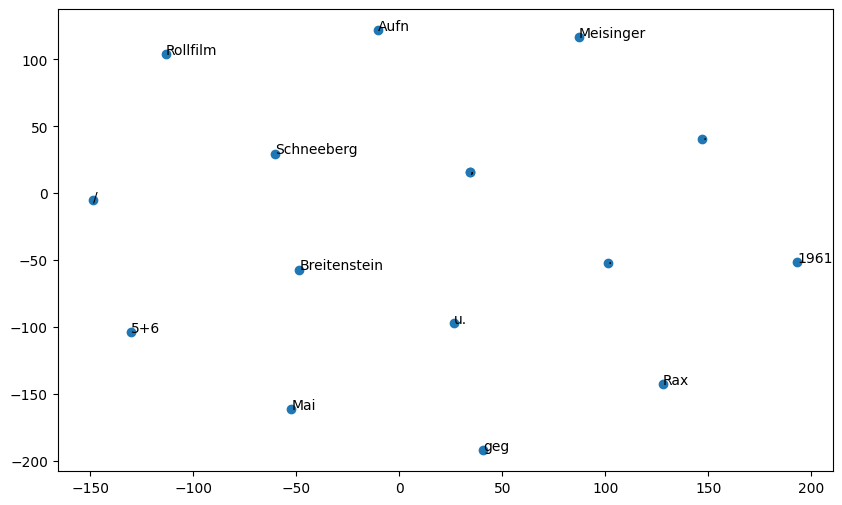

In [31]:
# Visualize word vectors using t-SNE
vectors = np.array([token.vector for token in doc if token.has_vector])
labels = [token.text for token in doc if token.has_vector]

# Check if we have enough samples for the perplexity value (default is 30)
perplexity_value = min(30, vectors.shape[0] - 1)

tsne = TSNE(n_components=2, perplexity=perplexity_value)
transformed = tsne.fit_transform(vectors)

plt.figure(figsize=(10, 6))
plt.scatter(transformed[:, 0], transformed[:, 1])

for i, label in enumerate(labels):
    plt.annotate(label, (transformed[i, 0], transformed[i, 1]))

plt.show()

In [32]:
for token in doc:
    if token.has_vector:
        print(f"Words similar to {token.text}:")
        similar_words = [w for w in doc if w.similarity(token) > 0.7 and w != token]
        for word in similar_words:
            print(f"  {word.text}")


Words similar to Breitenstein:
Words similar to geg:
Words similar to .:
  .
Words similar to Schneeberg:
Words similar to u.:
Words similar to Rax:
Words similar to Aufn:
Words similar to .:
  .
Words similar to Meisinger:
Words similar to ,:
  ,
Words similar to Mai:
Words similar to 1961:
Words similar to Rollfilm:
Words similar to /:
Words similar to 5+6:
Words similar to ,:
  ,


/tmp/ipykernel_15953/3411540385.py:4: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similar_words = [w for w in doc if w.similarity(token) > 0.7 and w != token]


Processing 38.txt:
Processing 48.txt:
Processing 59.txt:
Processing 15.txt:
Processing 10.txt:
Processing 54.txt:
Processing 42.txt:
Processing 49.txt:
Processing 52.txt:
Processing 36.txt:
Processing 20.txt:
Processing 11.txt:
Processing 24.txt:
Processing 31.txt:
Processing 39.txt:
Processing 41.txt:
Processing 19.txt:
Processing 29.txt:
Processing 44.txt:
Processing 32.txt:
Processing 26.txt:
Processing 47.txt:
Processing 30.txt:
Processing 61.txt:
Processing 5.txt:
Processing 55.txt:
Processing 9.txt:
Processing 3.txt:
Processing 27.txt:
Processing 35.txt:
Processing 53.txt:
Processing 60.txt:
Processing 2.txt:
Processing 4.txt:
Processing 22.txt:
Processing 18.txt:
Processing 8.txt:
Processing 6.txt:
Processing 46.txt:
Processing 17.txt:
Processing 62.txt:
Processing 57.txt:
Processing 40.txt:
Processing 13.txt:
Processing 45.txt:
Processing 56.txt:
Processing 1.txt:
Processing 34.txt:
Processing 7.txt:
Processing 21.txt:
Processing 28.txt:
Processing 23.txt:
Processing 25.txt:
Pr

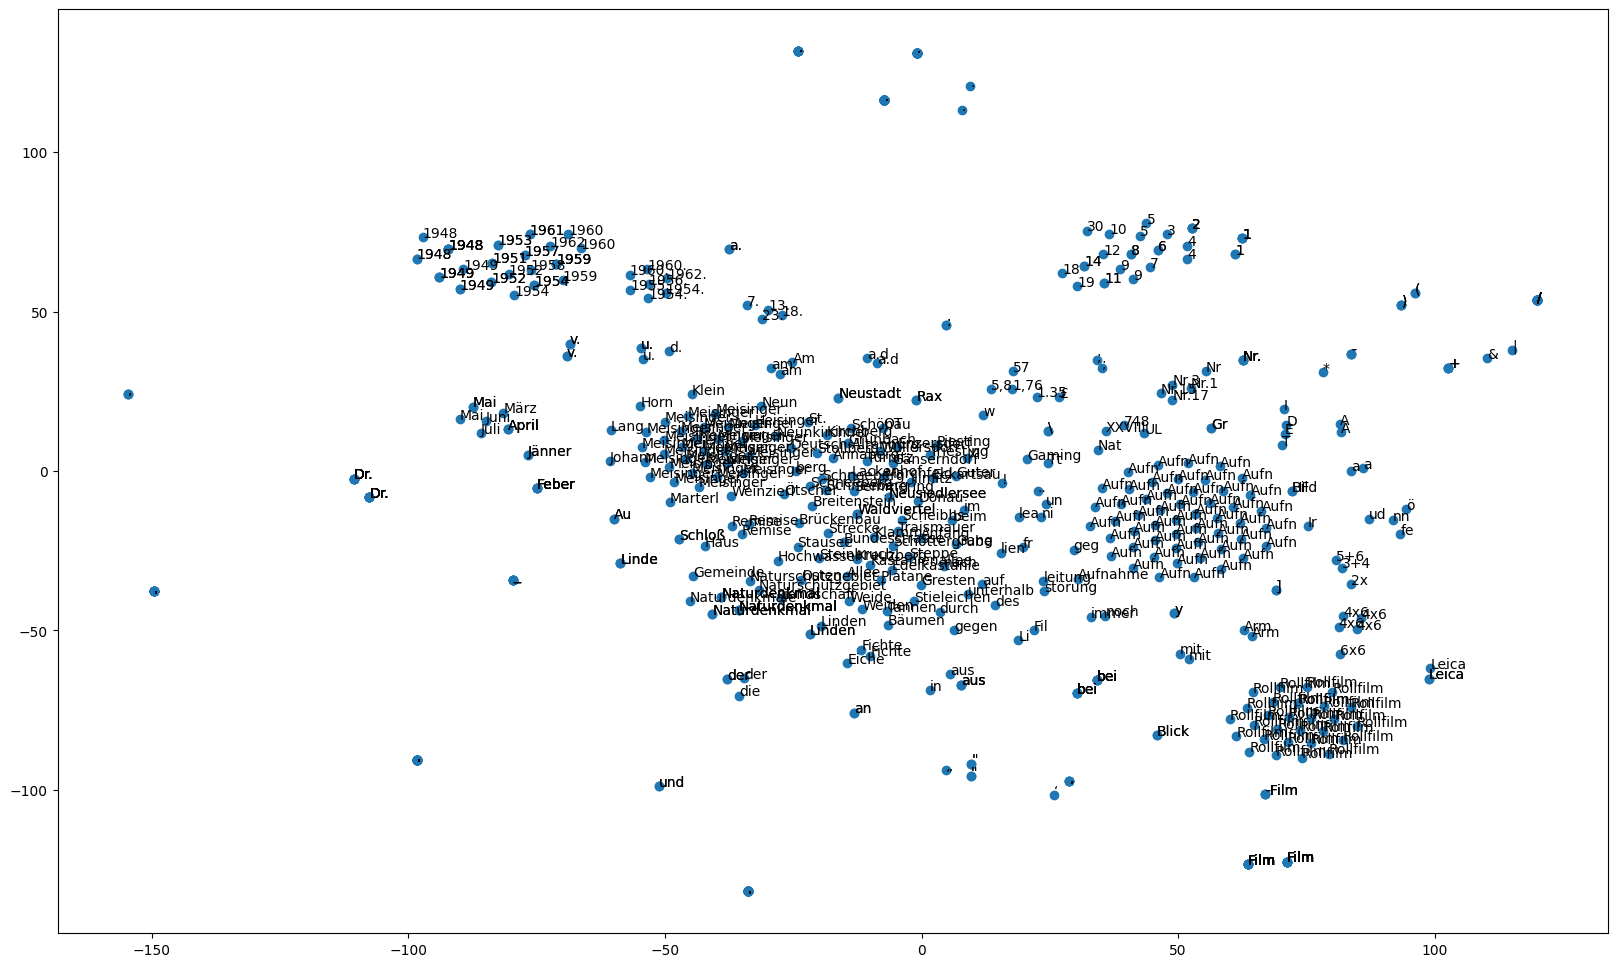

In [37]:
import os
import spacy
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

nlp = spacy.load("de_core_news_lg")

# Function to process a single text file
def process_text_file(file_path):
    with open(file_path, "r") as file:
        txt = file.read()
    doc = nlp(txt)
    return doc

# Folder containing the text files
txts_folder = "ab_output"

# List to store all tokens and vectors
all_vectors = []
all_labels = []

# Process each text file in the folder
for txt_file in os.listdir(txts_folder):
    file_path = os.path.join(txts_folder, txt_file)
    doc = process_text_file(file_path)
    print(f"Processing {txt_file}:")
    
    # for ent in doc.ents:
    #     print(f"{ent.text}: {ent.label_}")
    
    for token in doc:
        if token.has_vector:
            all_vectors.append(token.vector)
            all_labels.append(token.text)

# Convert lists to numpy arrays
all_vectors = np.array(all_vectors)
all_labels = np.array(all_labels)

# Visualize word vectors using t-SNE
perplexity_value = min(30, all_vectors.shape[0] - 1)
tsne = TSNE(n_components=2, perplexity=perplexity_value)
transformed = tsne.fit_transform(all_vectors)

plt.figure(figsize=(20, 12))
plt.scatter(transformed[:, 0], transformed[:, 1])

for i, label in enumerate(all_labels):
    plt.annotate(label, (transformed[i, 0], transformed[i, 1]))

plt.show()

Processing 38.txt:
Processing 48.txt:
Processing 59.txt:
Processing 15.txt:
Processing 10.txt:
Processing 54.txt:
Processing 42.txt:
Processing 49.txt:
Processing 52.txt:
Processing 36.txt:
Processing 20.txt:
Processing 11.txt:
Processing 24.txt:
Processing 31.txt:
Processing 39.txt:
Processing 41.txt:
Processing 19.txt:
Processing 29.txt:
Processing 44.txt:
Processing 32.txt:
Processing 26.txt:
Processing 47.txt:
Processing 30.txt:
Processing 61.txt:
Processing 5.txt:
Processing 55.txt:
Processing 9.txt:
Processing 3.txt:
Processing 27.txt:
Processing 35.txt:
Processing 53.txt:
Processing 60.txt:
Processing 2.txt:
Processing 4.txt:
Processing 22.txt:
Processing 18.txt:
Processing 8.txt:
Processing 6.txt:
Processing 46.txt:
Processing 17.txt:
Processing 62.txt:
Processing 57.txt:
Processing 40.txt:
Processing 13.txt:
Processing 45.txt:
Processing 56.txt:
Processing 1.txt:
Processing 34.txt:
Processing 7.txt:
Processing 21.txt:
Processing 28.txt:
Processing 23.txt:
Processing 25.txt:
Pr

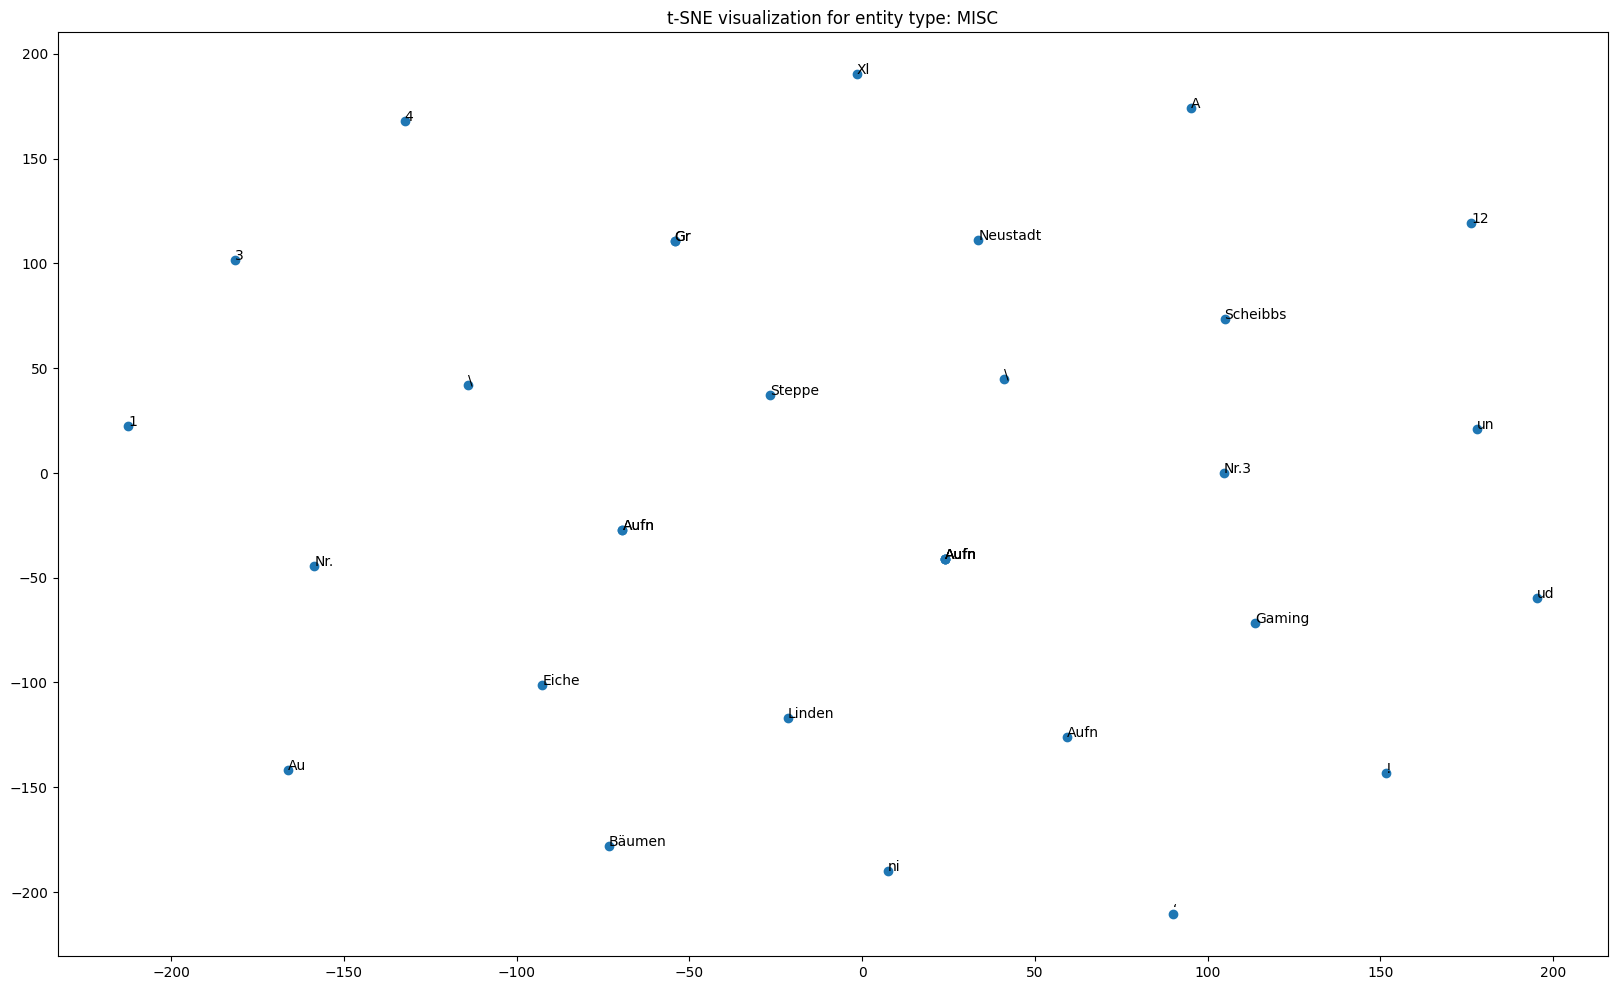

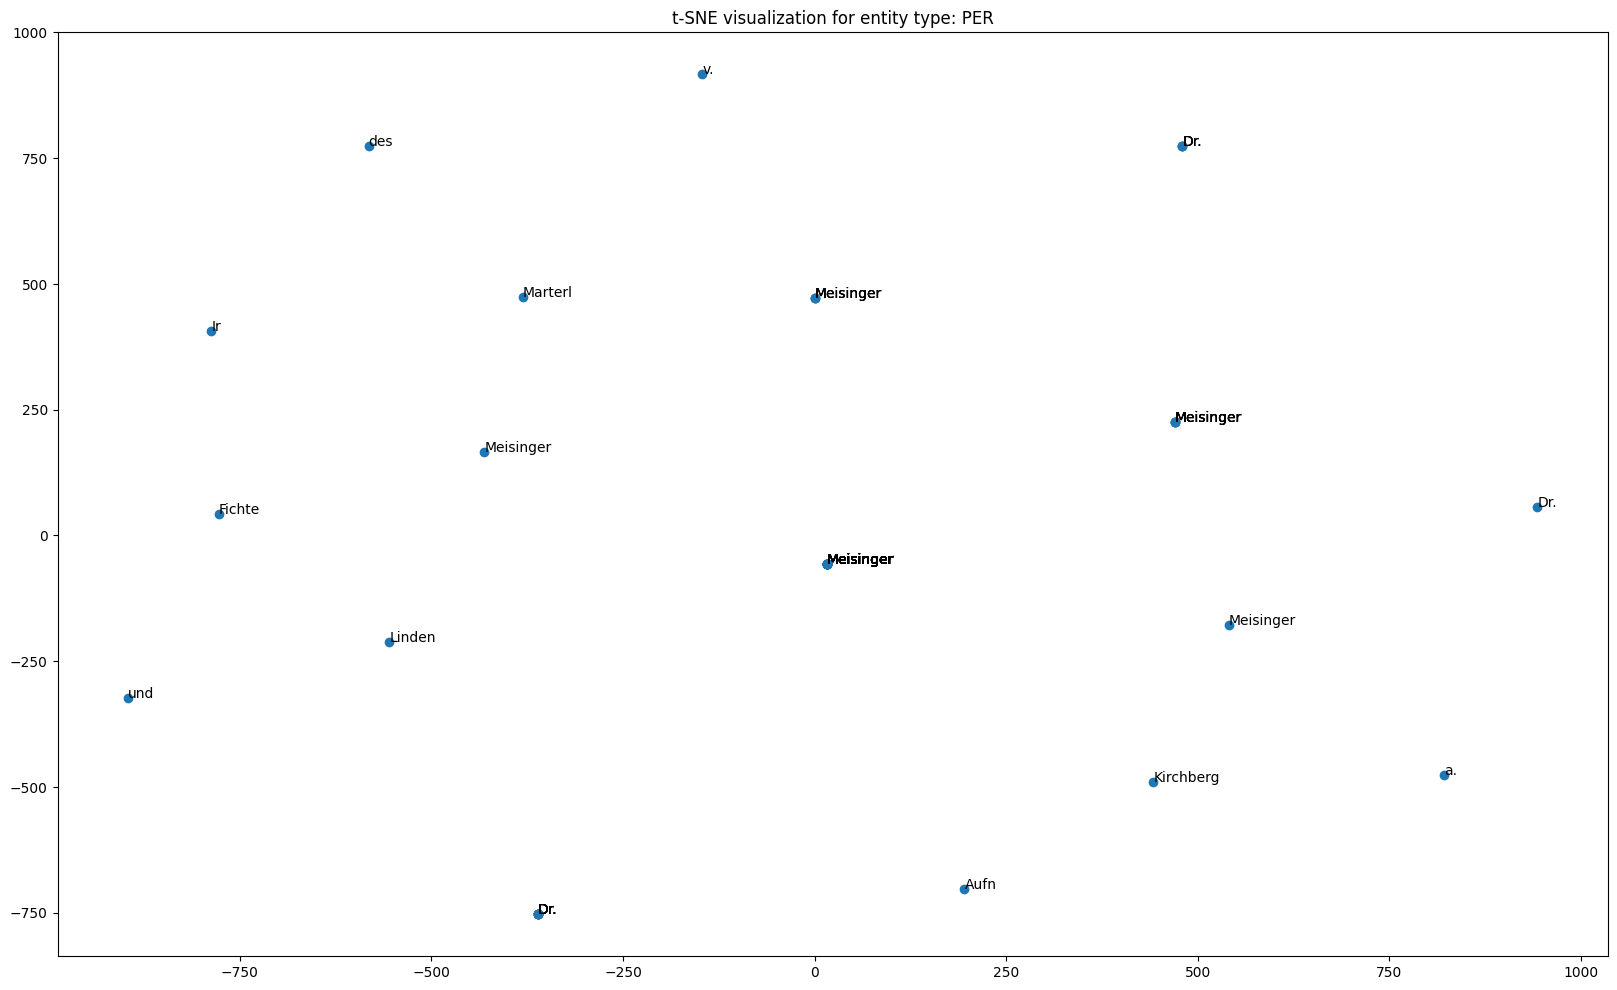

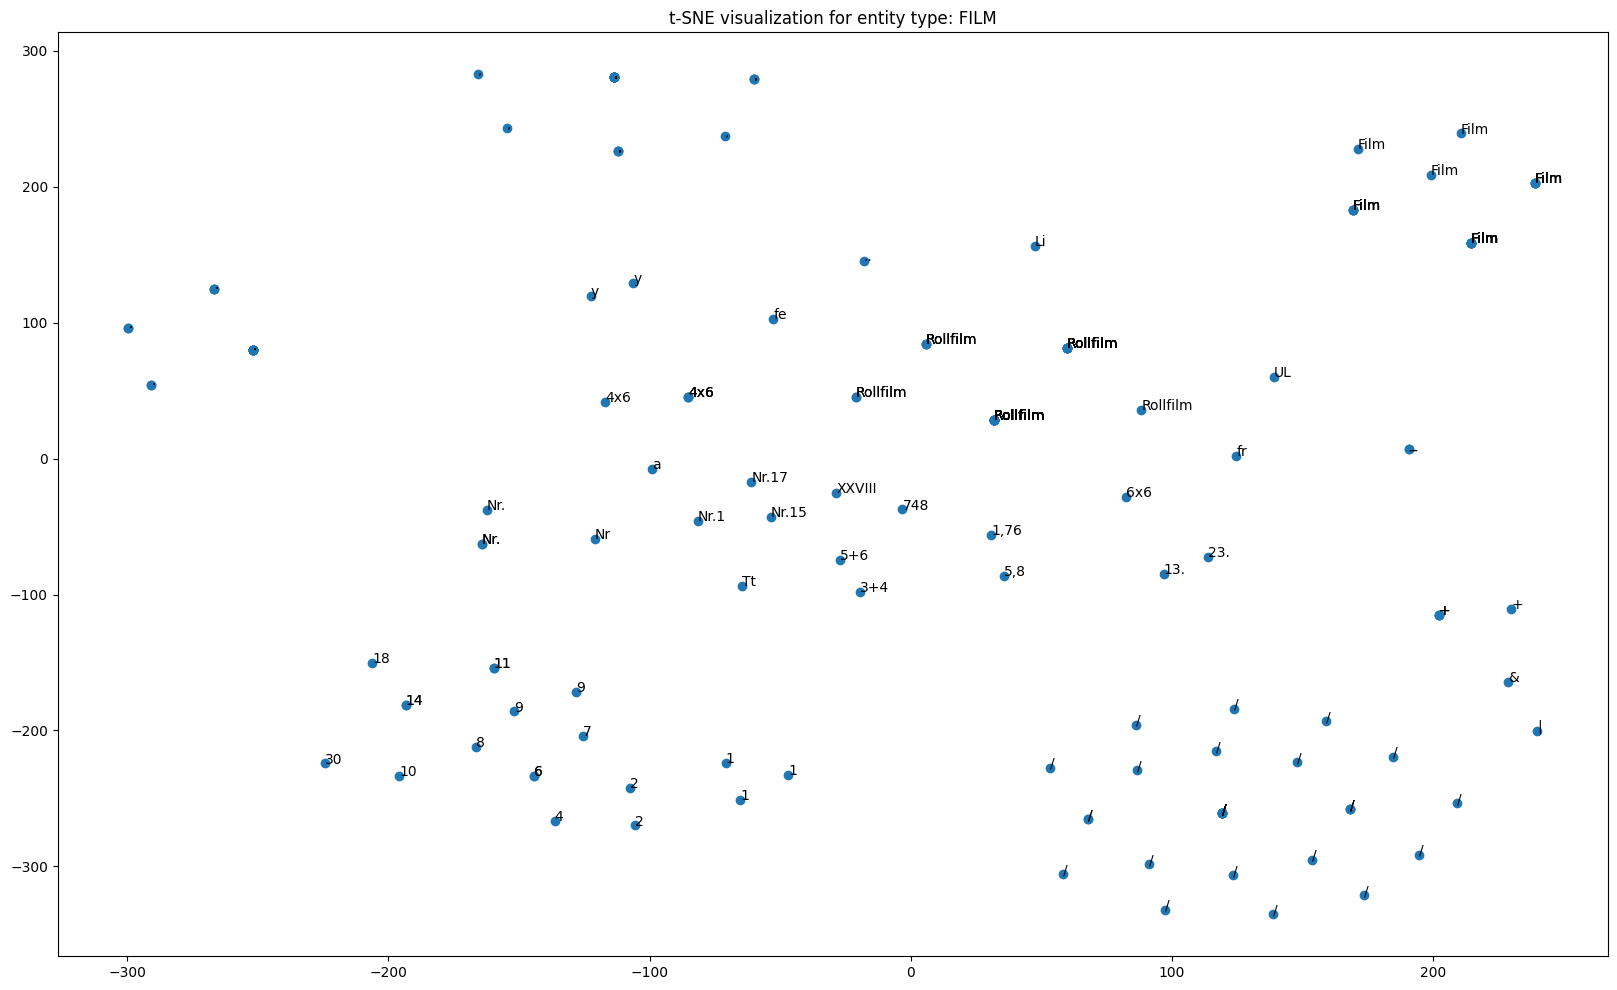

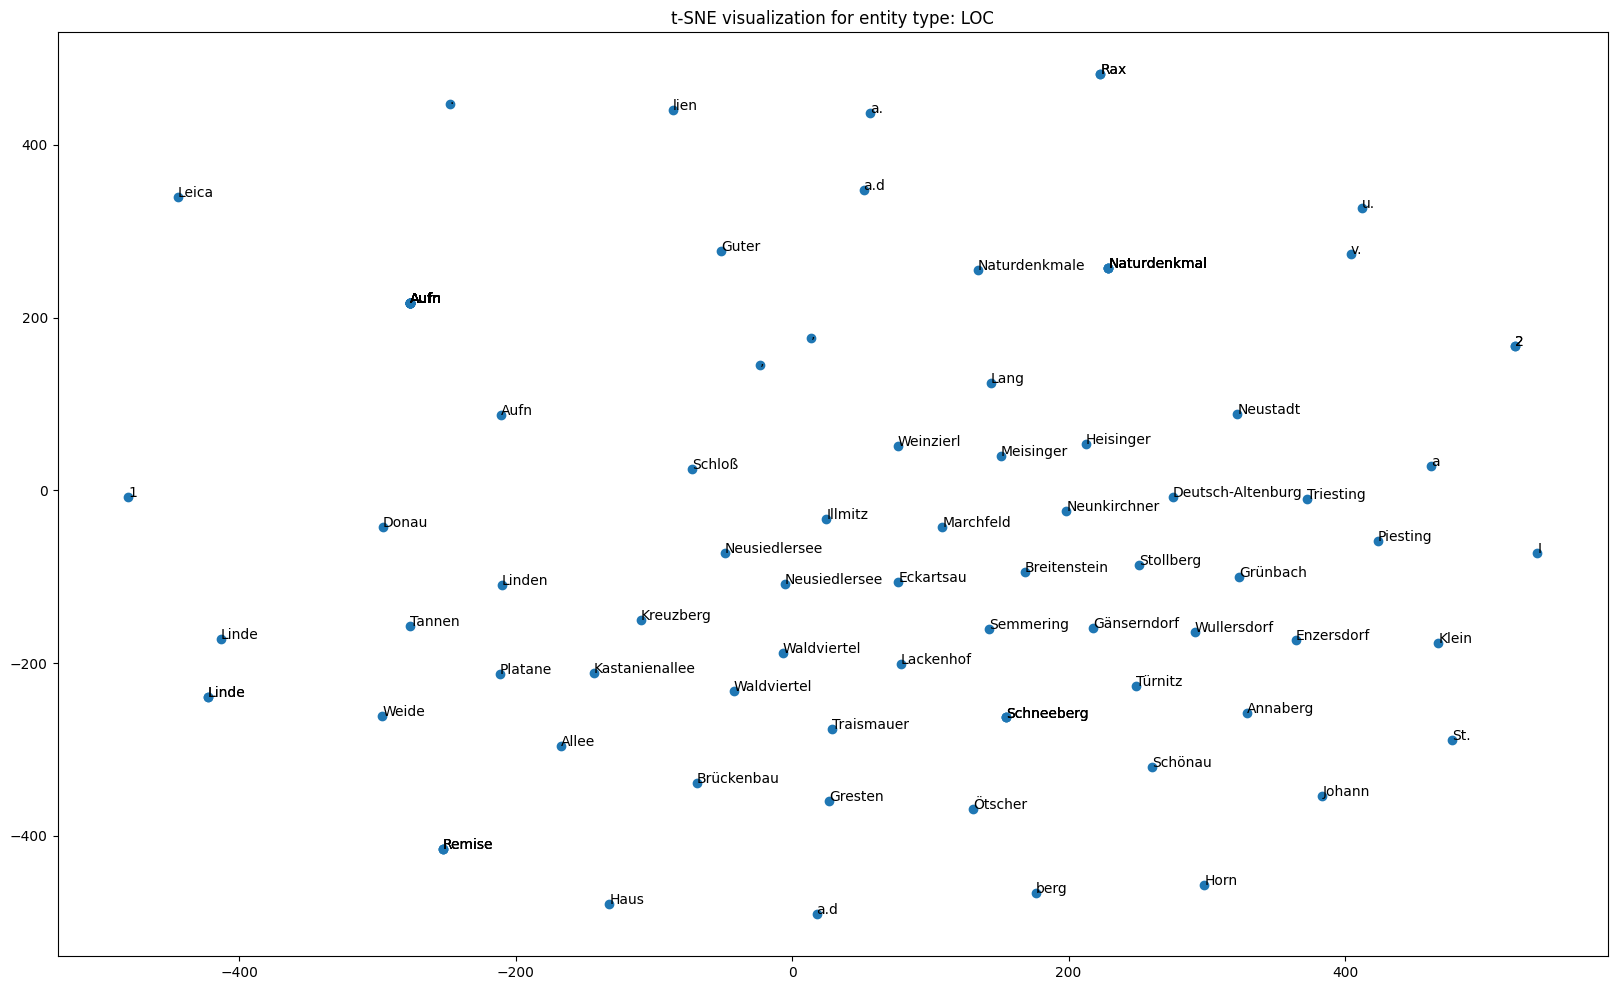

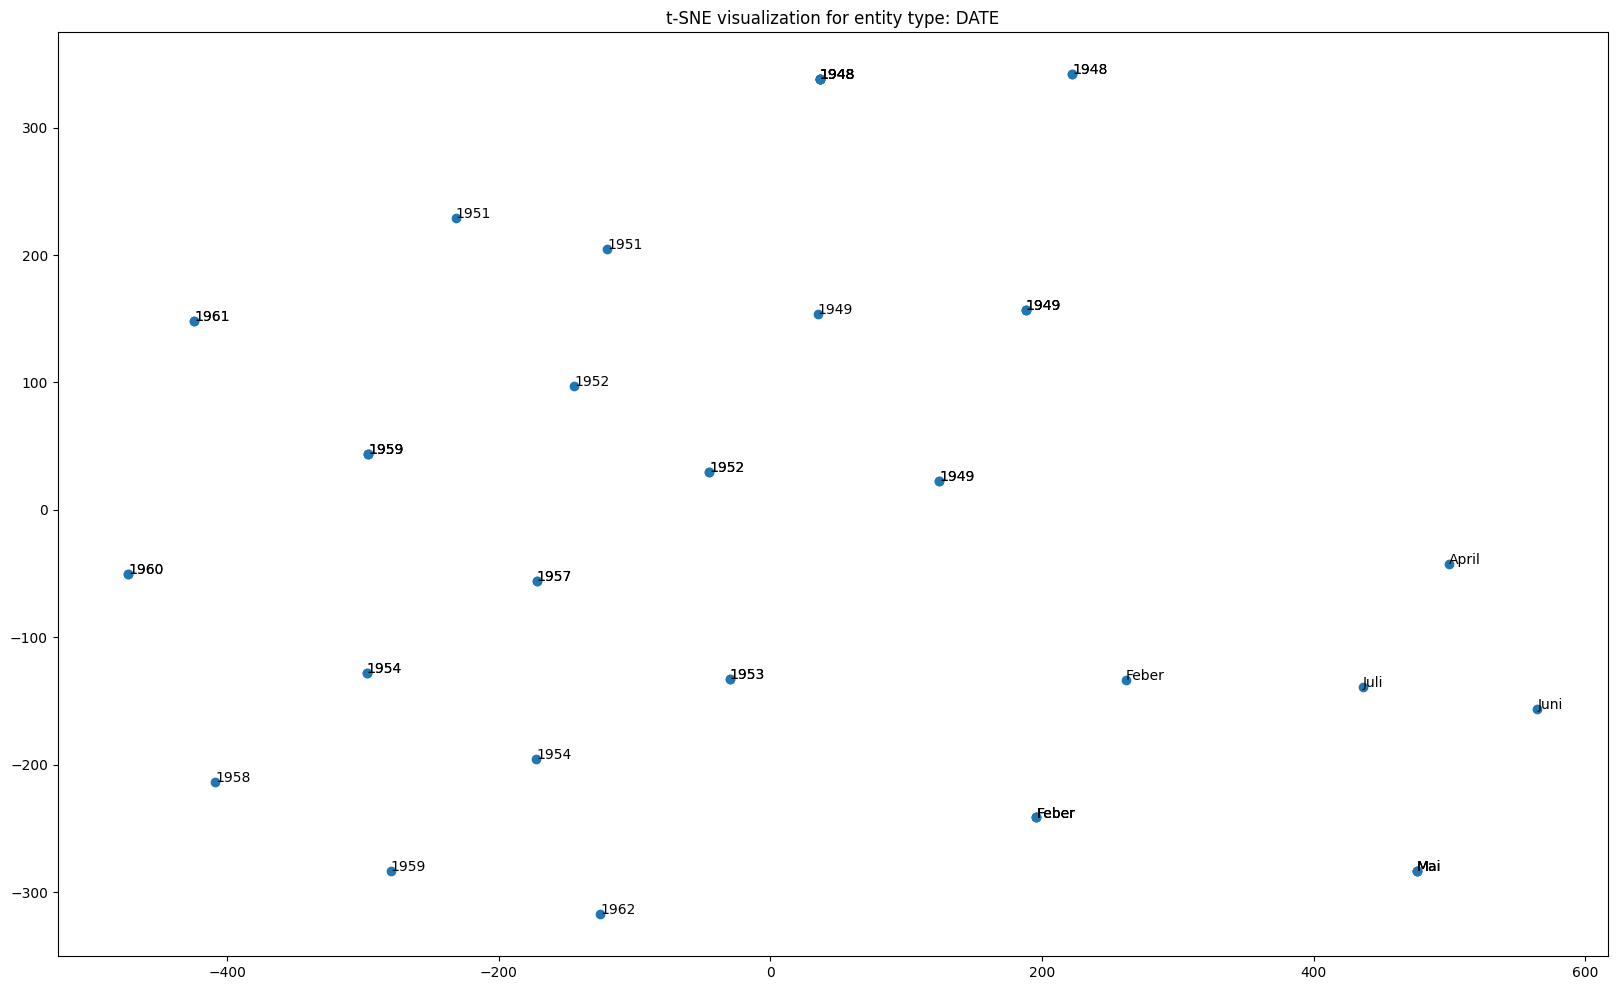

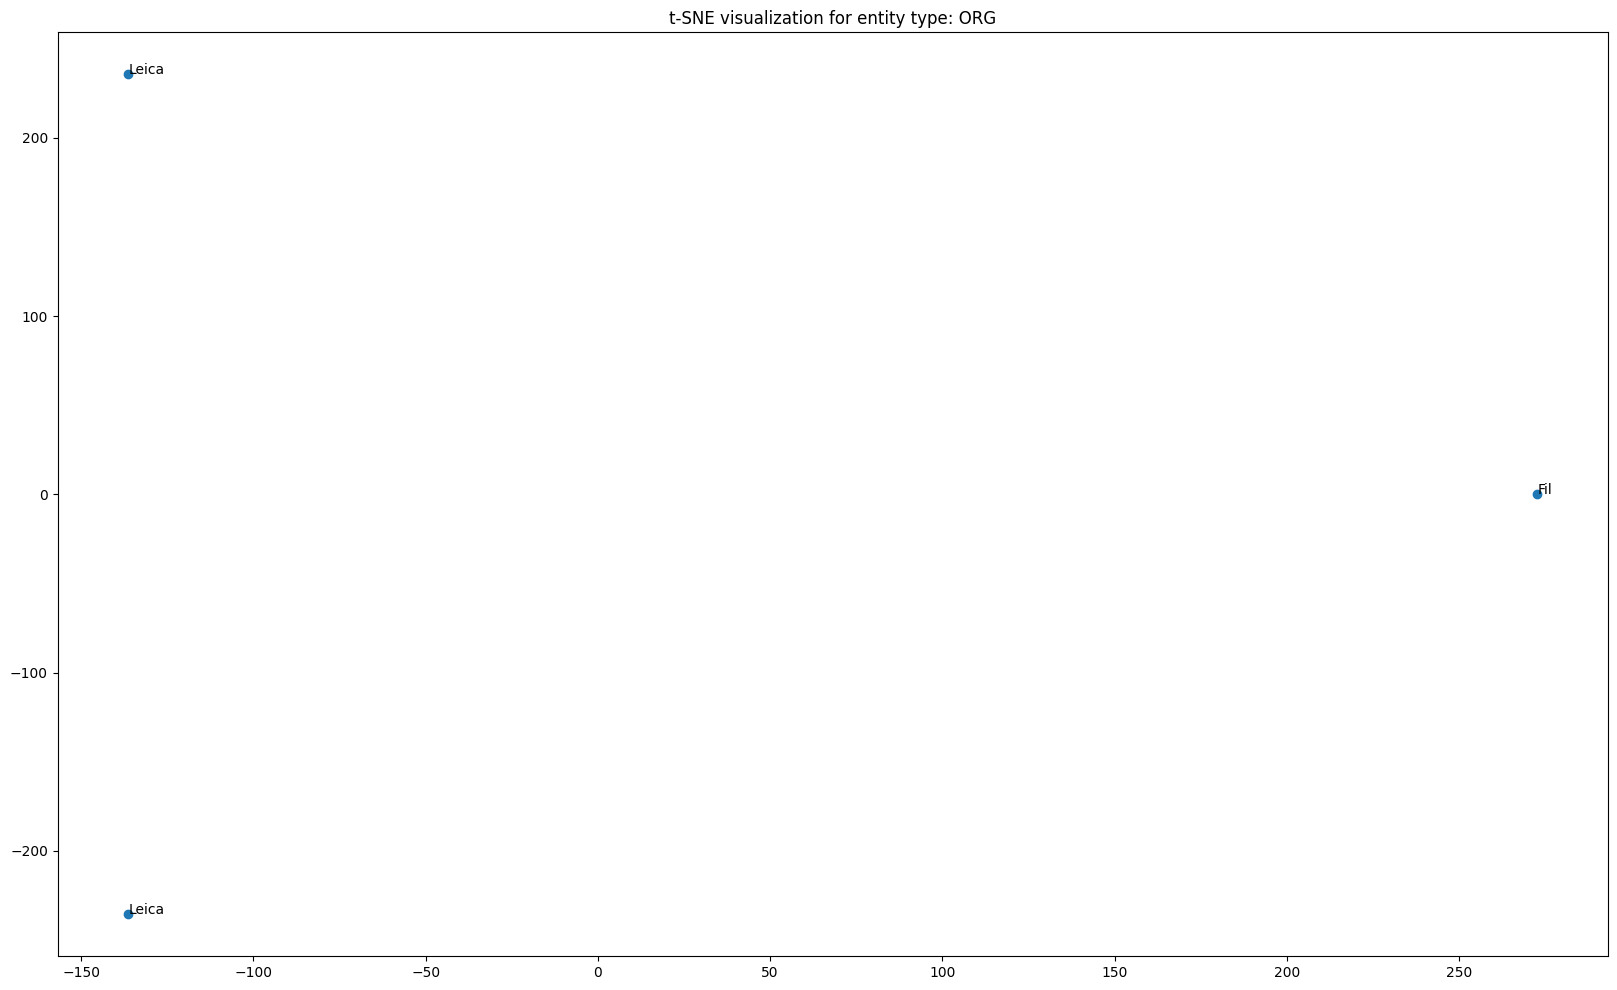

In [12]:
txts_folder = "ab_output"

# Dictionary to store vectors and labels per entity type
entity_vectors = {}

# Process each text file in the folder
for txt_file in os.listdir(txts_folder):
    file_path = os.path.join(txts_folder, txt_file)
    doc = process_text_file(file_path)
    print(f"Processing {txt_file}:")

    for ent in doc.ents:
        if ent.label_ not in entity_vectors:
            entity_vectors[ent.label_] = {"vectors": [], "labels": []}

        for token in ent:
            if token.has_vector:
                entity_vectors[ent.label_]["vectors"].append(token.vector)
                entity_vectors[ent.label_]["labels"].append(token.text)

# Visualize word vectors using t-SNE for each entity type
for entity, data in entity_vectors.items():
    vectors = np.array(data["vectors"])
    labels = np.array(data["labels"])

    if vectors.shape[0] > 0:  # Ensure there are vectors to process
        perplexity_value = min(30, vectors.shape[0] - 1)
        tsne = TSNE(n_components=2, perplexity=perplexity_value)
        transformed = tsne.fit_transform(vectors)

        plt.figure(figsize=(20, 12))
        plt.scatter(transformed[:, 0], transformed[:, 1])

        for i, label in enumerate(labels):
            plt.annotate(label, (transformed[i, 0], transformed[i, 1]))

        plt.title(f't-SNE visualization for entity type: {entity}')
        plt.show()
    else:
        print(f"No vectors found for entity type: {entity}")

In [39]:
def find_similar_words(doc, threshold=0.3):
    for token in doc:
        if token.has_vector:
            print(f"Words similar to {token.text}:")
            similar_words = [w for w in doc if w.similarity(token) > threshold and w != token]
            for word in similar_words:
                print(f"  {word.text}")


for txt_file in os.listdir(txts_folder):
    file_path = os.path.join(txts_folder, txt_file)
    doc = process_text_file(file_path)
    print(f"Finding similar words in {txt_file}:")
    find_similar_words(doc)

# Spot patterns
def find_patterns_in_similar_words(txts_folder, threshold=0.3):
    for txt_file in os.listdir(txts_folder):
        file_path = os.path.join(txts_folder, txt_file)
        doc = process_text_file(file_path)
        print(f"Patterns in {txt_file}:")
        similar_words_dict = {}
        for token in doc:
            if token.has_vector:
                similar_words = [w.text for w in doc if w.similarity(token) > threshold and w != token]
                if similar_words:
                    similar_words_dict[token.text] = similar_words
        if similar_words_dict:
            for key, value in similar_words_dict.items():
                print(f"{key}: {value}")
        print()

find_patterns_in_similar_words(txts_folder)

Finding similar words in 38.txt:
Words similar to Aufn:
Words similar to .:
  ,
Words similar to Meisinger:
Words similar to ,:
  .
Words similar to April:
Words similar to 1962.:
Words similar to Rollfilm:
Words similar to /:
  7
  +
  6
Words similar to 7:
  /
  +
  6
Words similar to +:
  /
  7
  6
Words similar to 6:
  /
  7
  +
Finding similar words in 48.txt:
Words similar to Waldviertel:
Words similar to Film:
Finding similar words in 59.txt:
Words similar to ,:
  ,
Words similar to Feber:
Words similar to 1959:
Words similar to Rollfilm:
Words similar to 4x6:
Words similar to ,:
  ,
Words similar to Nr.:
Words similar to UL:
Finding similar words in 15.txt:
Words similar to _:
  _
Words similar to Au:
Words similar to .:
  .
Words similar to 1948:
Words similar to _:
  _
Words similar to Film:
Words similar to .:
  .
Finding similar words in 10.txt:
Words similar to Scheibbs:
  Meisinger
  Jänner
Words similar to 1:
Words similar to Eiche:
Words similar to ,:
  .
  .
  .
  ,
  

/tmp/ipykernel_15953/4178894392.py:5: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similar_words = [w for w in doc if w.similarity(token) > threshold and w != token]


Finding similar words in 32.txt:
Words similar to Grünbach:
  Schneeberg
Words similar to a.:
Words similar to Schneeberg:
  Grünbach
Words similar to Aufn:
Words similar to .:
  .
  .
Words similar to 1955.:
Words similar to .:
  .
  .
Words similar to Nr.3:
Words similar to ud:
Words similar to .:
  .
  .
Words similar to 8:
Finding similar words in 26.txt:
Words similar to Remise:
Words similar to .:
  .
  .
  ,
Words similar to .:
  .
  .
  ,
Words similar to Aufn:
Words similar to .:
  .
  .
  ,
Words similar to ,:
  .
  .
  .
Words similar to Rollfilm:
Finding similar words in 47.txt:
Words similar to 1:
  1
  /
Words similar to Fichte:
  Naturdenkmal
  Meisinger
Words similar to ,:
  .
  ,
  ,
  .
  ,
  ,
Words similar to Naturdenkmal:
  Fichte
Words similar to Aufn:
Words similar to .:
  ,
  ,
  ,
  .
  ,
  ,
Words similar to Meisinger:
  Fichte
Words similar to ,:
  ,
  .
  ,
  .
  ,
  ,
Words similar to Mai:
Words similar to 1957:
Words similar to ,:
  ,
  .
  ,
  .
  ,
  ,
W

/tmp/ipykernel_15953/4178894392.py:25: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similar_words = [w.text for w in doc if w.similarity(token) > threshold and w != token]


Patterns in 29.txt:
,: ['.']
.: [',']

Patterns in 44.txt:
.: [',']
,: ['.']

Patterns in 32.txt:
Grünbach: ['Schneeberg']
Schneeberg: ['Grünbach']
.: ['.', '.']

Patterns in 26.txt:
.: ['.', '.', ',']
,: ['.', '.', '.']

Patterns in 47.txt:
1: ['1', '/']
Fichte: ['Naturdenkmal', 'Meisinger']
,: [',', '.', ',', ',', '.', ',']
Naturdenkmal: ['Fichte']
.: [',', '.', ',', ',', ',', ',']
Meisinger: ['Fichte']
/: ['1', '1']

Patterns in 30.txt:
.: ['.', 'und', '.', '.']
": ['"']
und: ['.', '.', '.', '.']
Marterl: ['Meisinger']
Meisinger: ['Marterl']

Patterns in 61.txt:
.: ['.', ',', ',', ',']
,: ['.', '.', ',', ',']
/: ['9']
5,8: ['9']
9: ['/', '5,8']

Patterns in 5.txt:
.: ['.']

Patterns in 55.txt:
Traismauer: ['Meisinger']
.: [',', ',', ',']
Meisinger: ['Traismauer']
,: ['.', ',', ',']
/: ['+', '11']
10: ['+', '11']
+: ['/', '10', '11']
11: ['/', '10', '+']

Patterns in 9.txt:
Horn: ['Meisinger']
,: [',']
Meisinger: ['Horn']

Patterns in 3.txt:
,: [',', 'noch', 'immer', '.', '.']
noch: 

In [6]:
import pandas as pd

txts_folder = "ab_output"

# Dictionary to store all unique words and their similar words
similar_words_dataset = {}

# Process each text file in the folder
for txt_file in os.listdir(txts_folder):
    file_path = os.path.join(txts_folder, txt_file)
    doc = process_text_file(file_path)
    print(f"Processing {txt_file}:")
    
    for token in doc:
        if token.has_vector and token.text not in similar_words_dataset:
            similar_words = [w.text for w in doc if w.similarity(token) > 0.3 and w != token]
            if similar_words:
                similar_words_dataset[token.text] = similar_words

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame([(word, similar) for word, similars in similar_words_dataset.items() for similar in similars], columns=["Word", "Similar_Word"])

# Save the DataFrame to a CSV file
df.to_csv("similar_words_dataset.csv", index=False)
df

Processing 38.txt:
Processing 48.txt:
Processing 59.txt:
Processing 15.txt:
Processing 10.txt:
Processing 54.txt:
Processing 42.txt:
Processing 49.txt:
Processing 52.txt:
Processing 36.txt:
Processing 20.txt:
Processing 11.txt:
Processing 24.txt:
Processing 31.txt:


/tmp/ipykernel_22580/1521831422.py:16: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similar_words = [w.text for w in doc if w.similarity(token) > 0.3 and w != token]


Processing 39.txt:
Processing 41.txt:
Processing 19.txt:
Processing 29.txt:
Processing 44.txt:
Processing 32.txt:
Processing 26.txt:
Processing 47.txt:
Processing 30.txt:
Processing 61.txt:
Processing 5.txt:
Processing 55.txt:
Processing 9.txt:
Processing 3.txt:
Processing 27.txt:
Processing 35.txt:
Processing 53.txt:
Processing 60.txt:
Processing 2.txt:
Processing 4.txt:
Processing 22.txt:
Processing 18.txt:
Processing 8.txt:
Processing 6.txt:
Processing 46.txt:
Processing 17.txt:
Processing 62.txt:
Processing 57.txt:
Processing 40.txt:
Processing 13.txt:
Processing 45.txt:
Processing 56.txt:
Processing 1.txt:
Processing 34.txt:
Processing 7.txt:
Processing 21.txt:
Processing 28.txt:
Processing 23.txt:
Processing 25.txt:
Processing 43.txt:
Processing 12.txt:
Processing 63.txt:
Processing 16.txt:
Processing 14.txt:
Processing 50.txt:
Processing 58.txt:
Processing 51.txt:
Processing 37.txt:
Processing 33.txt:


,Word,Similar_Word
0,.,","
1,",",.
2,/,7
3,/,+
4,/,6
...,...,...
165,Nr,XXVIII
166,XXVIII,v.
167,XXVIII,Nr
168,Weinzierl,Meisinger


Processing 38.txt:
Processing 48.txt:
Processing 59.txt:
Processing 15.txt:
Processing 10.txt:
Processing 54.txt:
Processing 42.txt:
Processing 49.txt:
Processing 52.txt:
Processing 36.txt:
Processing 20.txt:
Processing 11.txt:
Processing 24.txt:
Processing 31.txt:
Processing 39.txt:
Processing 41.txt:
Processing 19.txt:
Processing 29.txt:
Processing 44.txt:
Processing 32.txt:
Processing 26.txt:


/tmp/ipykernel_22580/1907393841.py:33: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similar_words = [w.text for w in doc if w.similarity(token) > 0.3 and w != token]


Processing 47.txt:
Processing 30.txt:
Processing 61.txt:
Processing 5.txt:
Processing 55.txt:
Processing 9.txt:
Processing 3.txt:
Processing 27.txt:
Processing 35.txt:
Processing 53.txt:
Processing 60.txt:
Processing 2.txt:
Processing 4.txt:
Processing 22.txt:
Processing 18.txt:
Processing 8.txt:
Processing 6.txt:
Processing 46.txt:
Processing 17.txt:
Processing 62.txt:
Processing 57.txt:
Processing 40.txt:
Processing 13.txt:
Processing 45.txt:
Processing 56.txt:
Processing 1.txt:
Processing 34.txt:
Processing 7.txt:
Processing 21.txt:
Processing 28.txt:
Processing 23.txt:
Processing 25.txt:
Processing 43.txt:
Processing 12.txt:
Processing 63.txt:
Processing 16.txt:
Processing 14.txt:
Processing 50.txt:
Processing 58.txt:
Processing 51.txt:
Processing 37.txt:
Processing 33.txt:
          Word                                      Similar_Words
0            .                                       ., und, ,, !
1            ,                ., und, ,, Stieleichen, immer, noch
2            

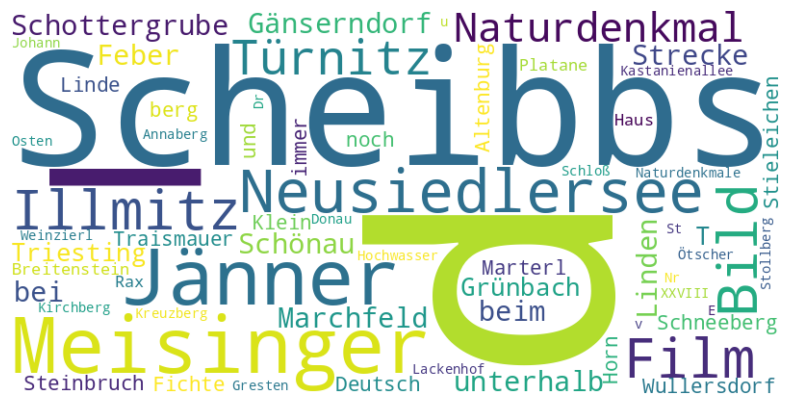

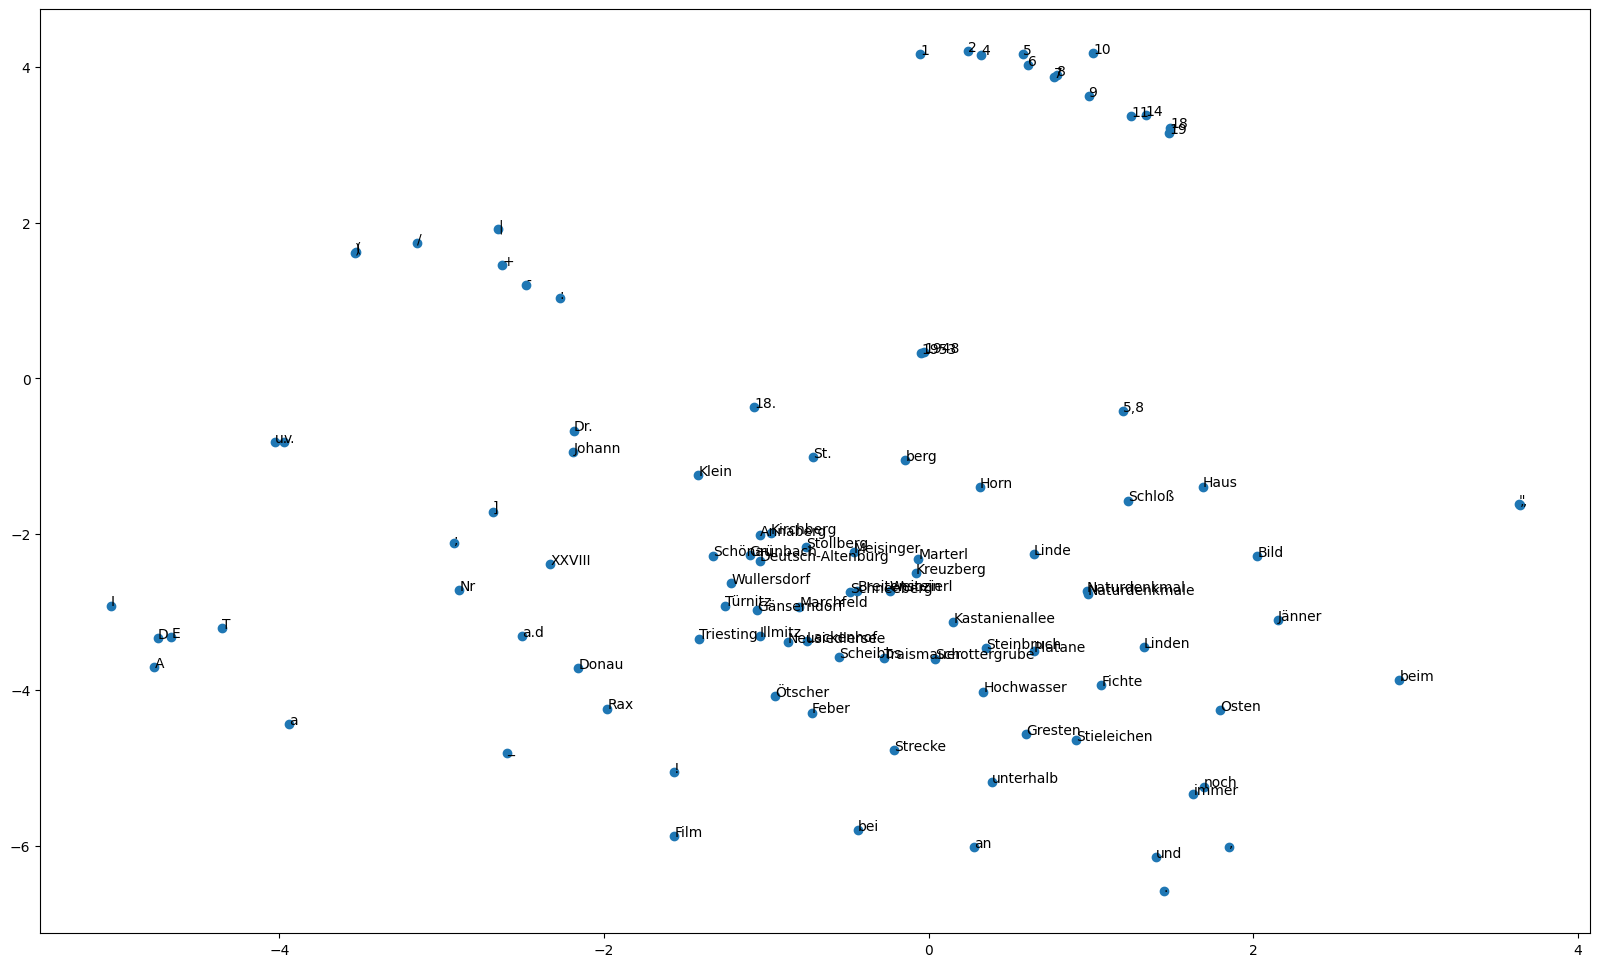

In [7]:
import os
import spacy
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the German large model
nlp = spacy.load("de_core_news_lg")

# Function to process a single text file
def process_text_file(file_path):
    with open(file_path, "r") as file:
        txt = file.read()
    doc = nlp(txt)
    return doc

# Folder containing the text files
txts_folder = "ab_output"

# Dictionary to store all unique words and their similar words
similar_words_dataset = {}

# Process each text file in the folder
for txt_file in os.listdir(txts_folder):
    file_path = os.path.join(txts_folder, txt_file)
    doc = process_text_file(file_path)
    print(f"Processing {txt_file}:")
    
    for token in doc:
        if token.has_vector:
            similar_words = [w.text for w in doc if w.similarity(token) > 0.3 and w != token]
            if similar_words:
                if token.text not in similar_words_dataset:
                    similar_words_dataset[token.text] = set()
                similar_words_dataset[token.text].update(similar_words)

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame([(word, ', '.join(similars)) for word, similars in similar_words_dataset.items()], columns=["Word", "Similar_Words"])

# Save the DataFrame to a CSV file
df.to_csv("similar_words_dataset.csv", index=False)
print(df)

# Visualize with WordCloud
all_words = ' '.join(df['Word'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Visualize word vectors using t-SNE
all_vectors = []
all_labels = []

for word in similar_words_dataset.keys():
    token = nlp(word)
    if token.has_vector:
        all_vectors.append(token.vector)
        all_labels.append(word)

# Convert lists to numpy arrays
all_vectors = np.array(all_vectors)
all_labels = np.array(all_labels)

# Visualize word vectors using t-SNE
if all_vectors.shape[0] > 0:  # Ensure there are vectors to process
    perplexity_value = min(30, all_vectors.shape[0] - 1)
    tsne = TSNE(n_components=2, perplexity=perplexity_value)
    transformed = tsne.fit_transform(all_vectors)

    plt.figure(figsize=(20, 12))
    plt.scatter(transformed[:, 0], transformed[:, 1])

    for i, label in enumerate(all_labels):
        plt.annotate(label, (transformed[i, 0], transformed[i, 1]))

    plt.show()
else:
    print("No vectors found for visualization.")

In [8]:
df

,Word,Similar_Words
0,.,"., und, ,, !"
1,",","., und, ,, Stieleichen, immer, noch"
2,/,"(, D, ), 7, +, 9, T, 14, /, a, 1, |, ], 2, 19,..."
3,7,"6, /, +"
4,+,"2, 9, 10, 8, /, 11, 7, 6, 1"
...,...,...
96,v.,"u., XXVIII"
97,Nr,XXVIII
98,XXVIII,"Nr, v."
99,Weinzierl,Meisinger


In [34]:
doc = process_text_file("ab_output/18.txt")
doc

Breitenstein geg.
Schneeberg u.Rax
Aufn.Meisinger,Mai 1961
Rollfilm Nr.94/5+6,


Breitenstein: LOC
Schneeberg: LOC
Rax
Aufn: LOC
Meisinger: PER
Nr.94/5+6: MISC


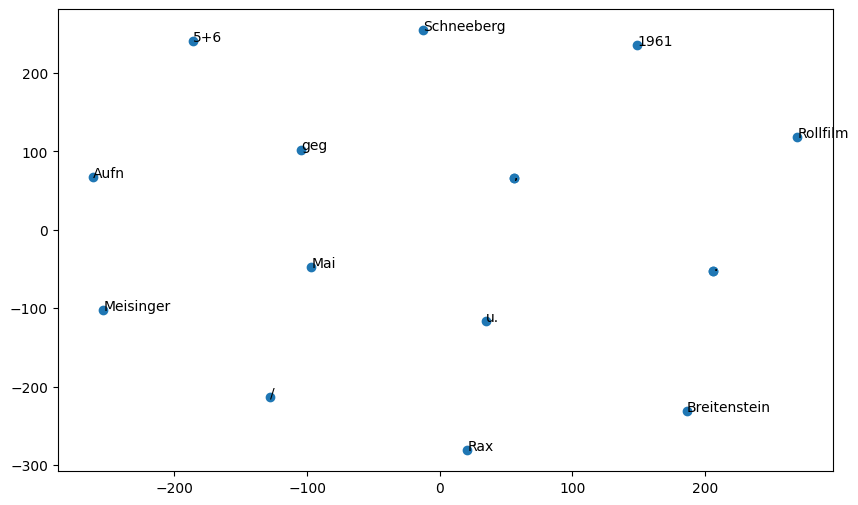

In [35]:
all_vectors = []
all_labels = []

for ent in doc.ents:
    print(f"{ent.text}: {ent.label_}")

# Collect vectors and labels for visualization
for token in doc:
    if token.has_vector:
        all_vectors.append(token.vector)
        all_labels.append(token.text)

# Convert lists to numpy arrays
all_vectors = np.array(all_vectors)
all_labels = np.array(all_labels)

# Visualize word vectors using t-SNE
perplexity_value = min(30, all_vectors.shape[0] - 1)
tsne = TSNE(n_components=2, perplexity=perplexity_value)
transformed = tsne.fit_transform(all_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(transformed[:, 0], transformed[:, 1])

for i, label in enumerate(all_labels):
    plt.annotate(label, (transformed[i, 0], transformed[i, 1]))

plt.show()

In [36]:
all_labels

array(['Breitenstein', 'geg', '.', 'Schneeberg', 'u.', 'Rax', 'Aufn', '.',
       'Meisinger', ',', 'Mai', '1961', 'Rollfilm', '/', '5+6', ','],
      dtype='<U12')

In [24]:
all_vectors

array([[-0.34734 , -0.20365 , -0.79679 , ...,  1.2953  ,  0.36839 ,
         1.8701  ],
       [ 2.8433  ,  1.9238  ,  0.68871 , ..., -3.7408  ,  1.1607  ,
        -0.75639 ],
       [ 4.883   , -1.241   ,  2.6465  , ...,  3.1105  ,  2.1134  ,
        -1.4311  ],
       ...,
       [-2.8129  , -5.075   ,  6.781   , ..., -4.7729  , -6.6697  ,
        -8.3289  ],
       [-1.5639  ,  0.94126 , -1.7411  , ..., -0.51769 ,  2.1813  ,
         0.057462],
       [ 2.862   , -2.0346  , -1.0418  , ...,  2.2365  ,  4.199   ,
         3.063   ]], dtype=float32)